In [1]:
!pip install transformers -U
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

##**Import required libraries**

In [2]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

##**Load the dataset**

In [3]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
java_file_path = '/content/drive/MyDrive/Wajid Ali/FYP/Dataset/java.csv'
java_df = pd.read_csv(java_file_path)
train_data = java_df[java_df['partition'] == 1].sample(n=800, random_state=1)
test_data = java_df[java_df['partition'] == 0].sample(n=200, random_state=1)
java_df = pd.concat([train_data, test_data])

print(java_df.head)
print(java_df.size)

Mounted at /content/drive
<bound method NDFrame.head of        comment_sentence_id                           class  \
24762                 5873      IMIContainerDMContext.java   
68949                 1099   TestRouterWebServiceUtil.java   
57854                 3453              Preconditions.java   
49879                 6579              QtPDOMVisitor.java   
40731                 5568        FSPermissionChecker.java   
...                    ...                             ...   
30043                11154              CommonBuilder.java   
47459                12296  DataGeneratorCacheManager.java   
50586                 7286              TypeDataStore.java   
67236                 2127                   IInclude.java   
36871                 9845                     MapKey.java   

                                        comment_sentence  partition  \
24762  Contributors:\n *     Ericsson - initial API a...          1   
68949  test class to validate routerwebserviceutil me... 

In [4]:
print(java_df['category'].unique())
print(java_df['category'].nunique())
print(java_df['partition']==0)
print(java_df)

['usage' 'rational' 'summary' 'deprecation' 'Pointer' 'Expand' 'Ownership']
7
24762    False
68949    False
57854    False
49879    False
40731    False
         ...  
30043     True
47459     True
50586     True
67236     True
36871     True
Name: partition, Length: 1000, dtype: bool
       comment_sentence_id                           class  \
24762                 5873      IMIContainerDMContext.java   
68949                 1099   TestRouterWebServiceUtil.java   
57854                 3453              Preconditions.java   
49879                 6579              QtPDOMVisitor.java   
40731                 5568        FSPermissionChecker.java   
...                    ...                             ...   
30043                11154              CommonBuilder.java   
47459                12296  DataGeneratorCacheManager.java   
50586                 7286              TypeDataStore.java   
67236                 2127                   IInclude.java   
36871                 9845      

In [5]:
categories = java_df['category'].unique()
categories

array(['usage', 'rational', 'summary', 'deprecation', 'Pointer', 'Expand',
       'Ownership'], dtype=object)

In [6]:
java_df['category'].nunique()

7

**Split the dataset into training and testing data**

In [7]:
# Filter training and test data
test_data = java_df[java_df['partition'] == 0]
train_data = java_df[java_df['partition'] == 1]
print(f"Size of the data frame: {java_df.size}")
df = train_data
print(f"Size of the training dataset: {train_data.size}")
print(f"Size of the test dataset: {test_data.size}")
combined_size = train_data.size + test_data.size
print(f"Combined size of training and testing dataset: {combined_size}")

Size of the data frame: 6000
Size of the training dataset: 4800
Size of the test dataset: 1200
Combined size of training and testing dataset: 6000


#**Preprocessing of the dataset**

In [8]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Replace non-alphanumeric characters with spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove stopwords and lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text



df['combo'] = df['class'] + " " + df['comment_sentence']  # Concatenate 'class' and 'comment_sentence'
df['combo'] = df['combo'].apply(preprocess_text)
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
<ipython-input-8-cf193394e2e2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combo'] = df['class'] + " " + df['comment_sentence']  # Concatenate 'class' and 'comment_sentence'


       comment_sentence_id                          class  \
24762                 5873     IMIContainerDMContext.java   
68949                 1099  TestRouterWebServiceUtil.java   
57854                 3453             Preconditions.java   
49879                 6579             QtPDOMVisitor.java   
40731                 5568       FSPermissionChecker.java   

                                        comment_sentence  partition  \
24762  Contributors:\n *     Ericsson - initial API a...          1   
68949  test class to validate routerwebserviceutil me...          1   
57854  however, the methods of this class have a larg...          1   
49879  A simple interface that is used to select node...          1   
40731                  @param snapshotId int snapshot ID          1   

       instance_type     category  \
24762              0        usage   
68949              0     rational   
57854              0      summary   
49879              0     rational   
40731              0 

<ipython-input-8-cf193394e2e2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combo'] = df['combo'].apply(preprocess_text)


#**Preprocess the test data as well**

In [9]:
test_data['combo'] = test_data['class'] + " " + test_data['comment_sentence']  # Concatenate 'class' and 'comment_sentence'
test_data['combo'] = test_data['combo'].apply(preprocess_text)
print(test_data.head())

       comment_sentence_id                           class  \
4259                  9781               IndentAction.java   
53003                 9703               IndentAction.java   
36288                 9262  AutotoolsNewProjectNature.java   
4172                  9694               LoggingUtils.java   
21808                11056                  ICElement.java   

                                        comment_sentence  partition  \
4259   \t\t\t// this is too intrusive, but will never...          0   
53003  \t * @return <code>true</code> if smart mode i...          0   
36288       \t * @param natureId the nature id to remove          0   
4172             \t * Equivalent to toString(obj, false)          0   
21808        \t * Modifier indicating a class destructor          0   

       instance_type  category  \
4259               1   summary   
53003              0  rational   
36288              0   Pointer   
4172               1   summary   
21808              0    Expand

<ipython-input-9-03fdaae9456f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['combo'] = test_data['class'] + " " + test_data['comment_sentence']  # Concatenate 'class' and 'comment_sentence'
<ipython-input-9-03fdaae9456f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['combo'] = test_data['combo'].apply(preprocess_text)


In [10]:
train_counts = train_data['category'].value_counts()
test_counts = test_data['category'].value_counts()
print(train_counts)
print(test_counts)

category
deprecation    131
summary        120
rational       120
Ownership      111
Expand         110
Pointer        105
usage          103
Name: count, dtype: int64
category
deprecation    36
rational       31
summary        31
Expand         29
Pointer        26
usage          25
Ownership      22
Name: count, dtype: int64


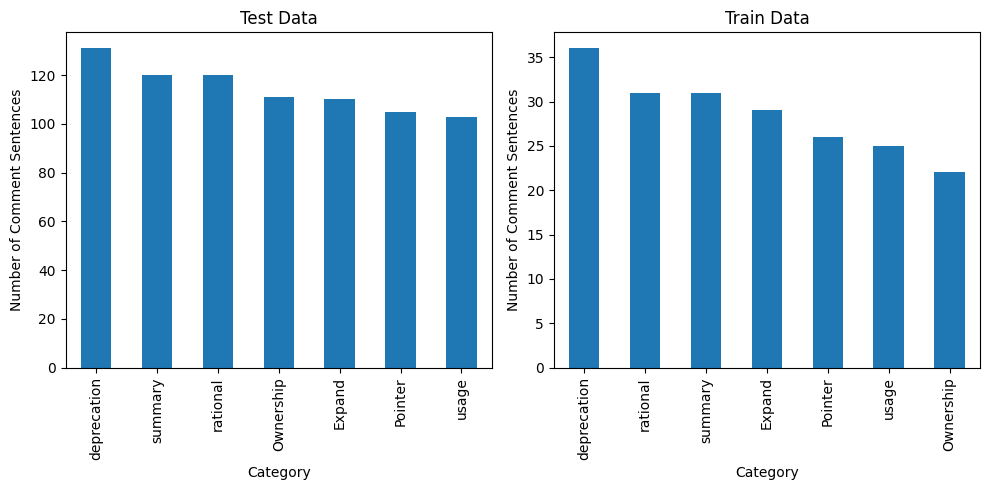

In [11]:
# Plot bar graphs for training and test data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train_counts.plot(kind='bar')
plt.title('Test Data')
plt.xlabel('Category')
plt.ylabel('Number of Comment Sentences')

plt.subplot(1, 2, 2)
test_counts.plot(kind='bar')
plt.title('Train Data')
plt.xlabel('Category')
plt.ylabel('Number of Comment Sentences')

plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

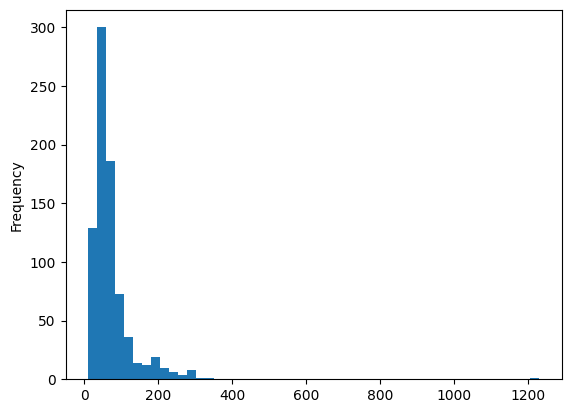

In [12]:
df['combo'].str.len().plot.hist(bins=50)

In [13]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
class CommentDataset(Dataset):
    def __init__(self, combos, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.combos = combos
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.combos)

    def __getitem__(self, idx):
        combo = str(self.combos[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            combo,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'combo_text': combo,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Keep it low to speed up training
    per_device_train_batch_size=32,  # Increase if GPU memory allows
    per_device_eval_batch_size=32,  # Increase if GPU memory allows
    warmup_steps=500,  # Adjust based on learning rate scheduler
    weight_decay=0.01,  # Regularization
    evaluation_strategy='no',  # Avoid evaluating to speed up training
    logging_dir='./logs',
    logging_steps=1000  # Less frequent logging
)

#**We will use all 7 categories for trainging the model**

In [16]:
categories

array(['usage', 'rational', 'summary', 'deprecation', 'Pointer', 'Expand',
       'Ownership'], dtype=object)

#**Classifier training and models saving**

In [17]:
import os

# Loop over categories
for category in categories:
    print(f"Training for category: {category}")
    train_data['label'] = (train_data['category'] == category).astype(int)
    test_data['label'] = (test_data['category'] == category).astype(int)

    # Create datasets
    train_dataset = CommentDataset(train_data['combo'].to_numpy(), train_data['label'].to_numpy(), tokenizer)
    test_dataset = CommentDataset(test_data['combo'].to_numpy(), test_data['label'].to_numpy(), tokenizer)  # Corrected from 'category' to 'combo'

    if len(train_dataset) > 0 and len(test_dataset) > 0:
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset
        )

        trainer.train()

        # Define the directory to save the model
        model_directory = f"/content/drive/MyDrive/Wajid Ali/{category}_classifier"

        # Create the directory if it does not exist
        if not os.path.exists(model_directory):
            os.makedirs(model_directory)

        # Save the model
        model.save_pretrained(model_directory)
        print(f"Model for {category} saved at {model_directory}")
    else:
        print(f"Skipping category {category} due to insufficient data.")


Training for category: usage


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model for usage saved at /content/drive/MyDrive/Wajid Ali/usage_classifier
Training for category: rational


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.

Step,Training Loss


Model for rational saved at /content/drive/MyDrive/Wajid Ali/rational_classifier
Training for category: summary


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.

Step,Training Loss


Model for summary saved at /content/drive/MyDrive/Wajid Ali/summary_classifier
Training for category: deprecation


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.

Step,Training Loss


Model for deprecation saved at /content/drive/MyDrive/Wajid Ali/deprecation_classifier
Training for category: Pointer


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.

Step,Training Loss


Model for Pointer saved at /content/drive/MyDrive/Wajid Ali/Pointer_classifier
Training for category: Expand


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.

Step,Training Loss


Model for Expand saved at /content/drive/MyDrive/Wajid Ali/Expand_classifier
Training for category: Ownership


<ipython-input-17-d825f15d7b6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = (train_data['category'] == category).astype(int)
<ipython-input-17-d825f15d7b6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = (test_data['category'] == category).astype(int)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.

Step,Training Loss


Model for Ownership saved at /content/drive/MyDrive/Wajid Ali/Ownership_classifier
